In [121]:
import astropy.units as u

from generate_priors_TOI import grab_all_priors
from RV_mini_pipeline import remake_rvfile
from generate_supporting_files import *
import sys
sys.path.insert(0, '/Users/jack/Research/pipelines/exofast_tools/scripts/lightcurve_pipeline/')
from lightcurve_pipeline import create_light_curve
import pandas as pd
import lightkurve as lk
import os
import numpy as np

## System parameters

In [85]:
toi = '4140'
ticid = '400103802'
rv_instrument = 'tres'
outpath = f'/Users/jack/Research/meep3/fits/toi{toi}/'

if os.path.exists(outpath) == False:
    os.makedirs(outpath)

## Downloading and formatting RVs
Ensure that the units and output filename are correct for the given instrument. Usually, CHIRON RVs are in km/s and TRES RVs are in m/s

In [86]:
path = outpath + f'toi{toi}.spctable'

with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

remake_rvfile(path, u.m/u.s, output_filename=outpath+f'{ticid}.{rv_instrument.upper()}.rv', 
              download_rvs=True, username='schulte', password=password, ticid=ticid, instrument=rv_instrument, verbose=False)

## Downloading TESS lightcurves
Run the first cell to see what lightcurves are available, and then modify and run the next cell to download the selected lightcurve. Make sure that you are downloading the highest cadence lightcurves available and that the data are of good quality.

After running the initial EXOFAST fit, you can check for a secondary eclipse by re-running these cells with the correct parameters.

In [ ]:
search_result = lk.search_lightcurve(f'TIC {ticid}')
df = search_result.table.to_pandas()
pd.set_option('display.max_rows', None)  # Show all rows
df = df[['author', 'mission', 'exptime']] # keep only relevant columns

# Filter the results to prefer SPOC, then TESS-SPOC, then QLP. If none of these exist, return all available data
def filter_spoc(group):
    if (group['author'] == 'SPOC').any():
        return group[group['author'] == 'SPOC']
    elif (group['author'] == 'TESS-SPOC').any():
        return group[group['author'] == 'TESS-SPOC']
    elif (group['author'] == 'QLP').any():
        return group[group['author'] == 'QLP']
    else:
        return group

filtered_df = df.groupby('mission', group_keys=False).apply(filter_spoc).reset_index(drop=True)
display(filtered_df.sort_values(by='mission')) # filtered data, sorted by TESS sector
# display(df.sort_values(by='mission').reset_index(drop=True)) # all data, sorted by TESS sector

,author,mission,exptime
0,DIAMANTE,TESS Sector,1800.0
1,TESS-SPOC,TESS Sector 19,1800.0
2,TESS-SPOC,TESS Sector 20,1800.0
3,TESS-SPOC,TESS Sector 26,1800.0
4,SPOC,TESS Sector 40,120.0
5,SPOC,TESS Sector 53,120.0
6,SPOC,TESS Sector 59,120.0
7,SPOC,TESS Sector 60,120.0
8,SPOC,TESS Sector 73,120.0
9,SPOC,TESS Sector 79,120.0


Sector: 79. Exposure time: 120 seconds.
Available ExoFOP tables: ['TOI', 'CTOI', "'"]. Defaulting to TOI
period:  4.2511214 duration:  2.823 h tc:  2459910.467019
per-point error value 0.003950057077260842
Transith depth: 0.013830, RMS: 0.0040, Depth/RMS: 3.488


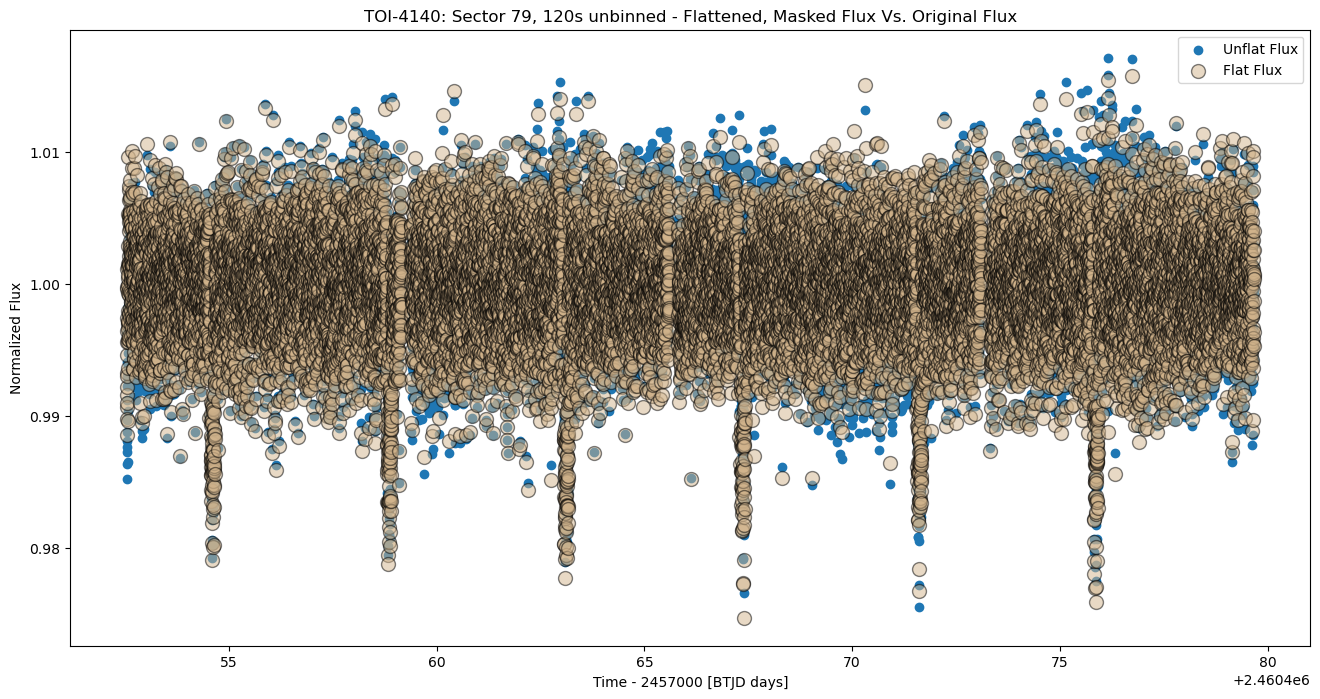

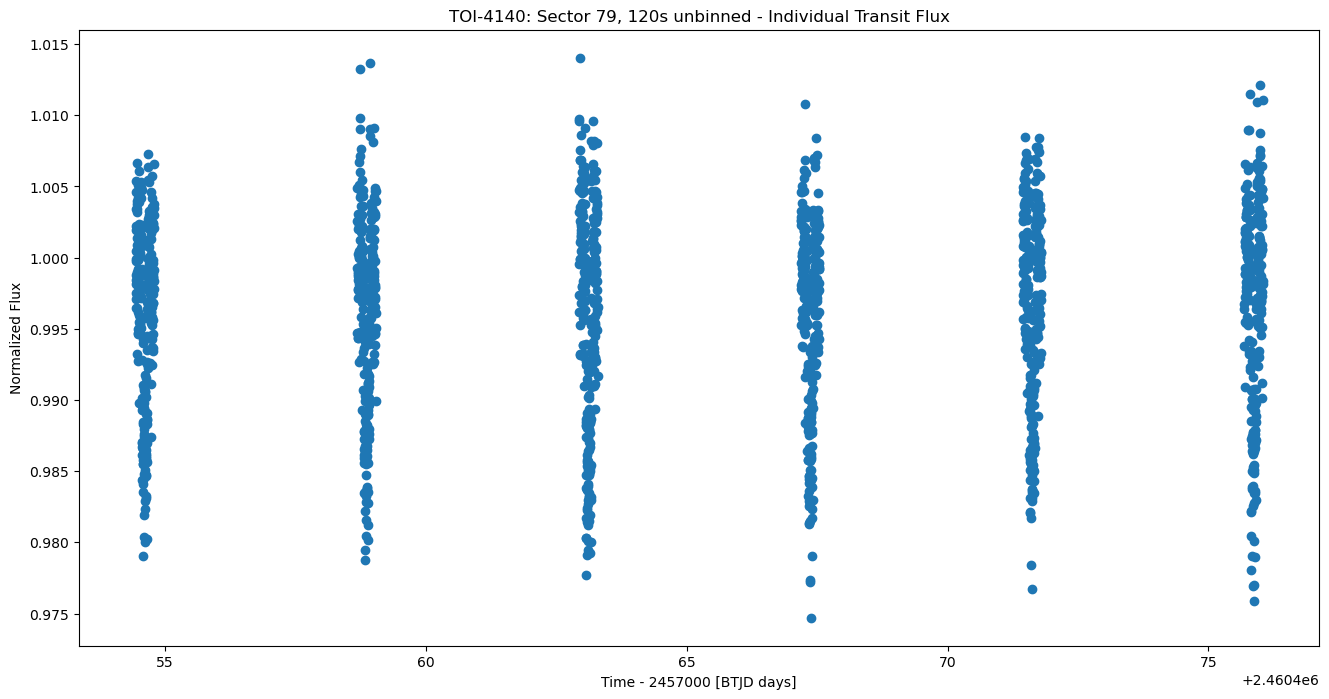

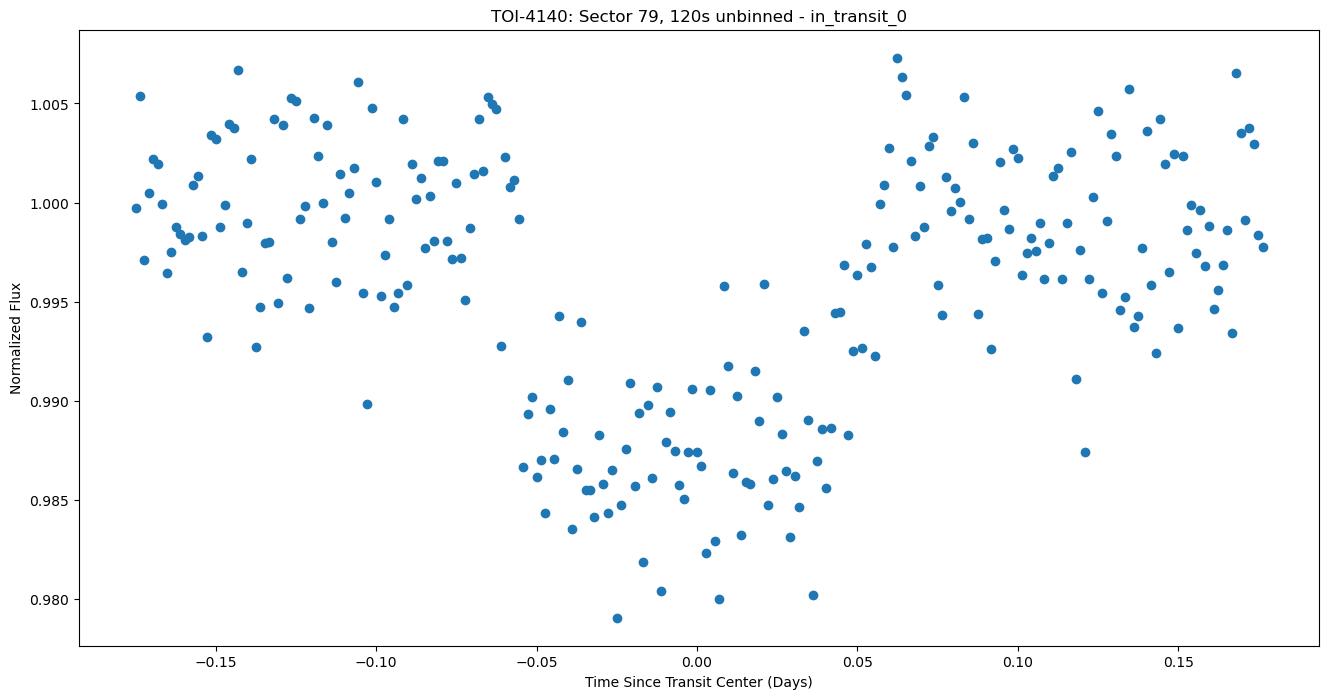

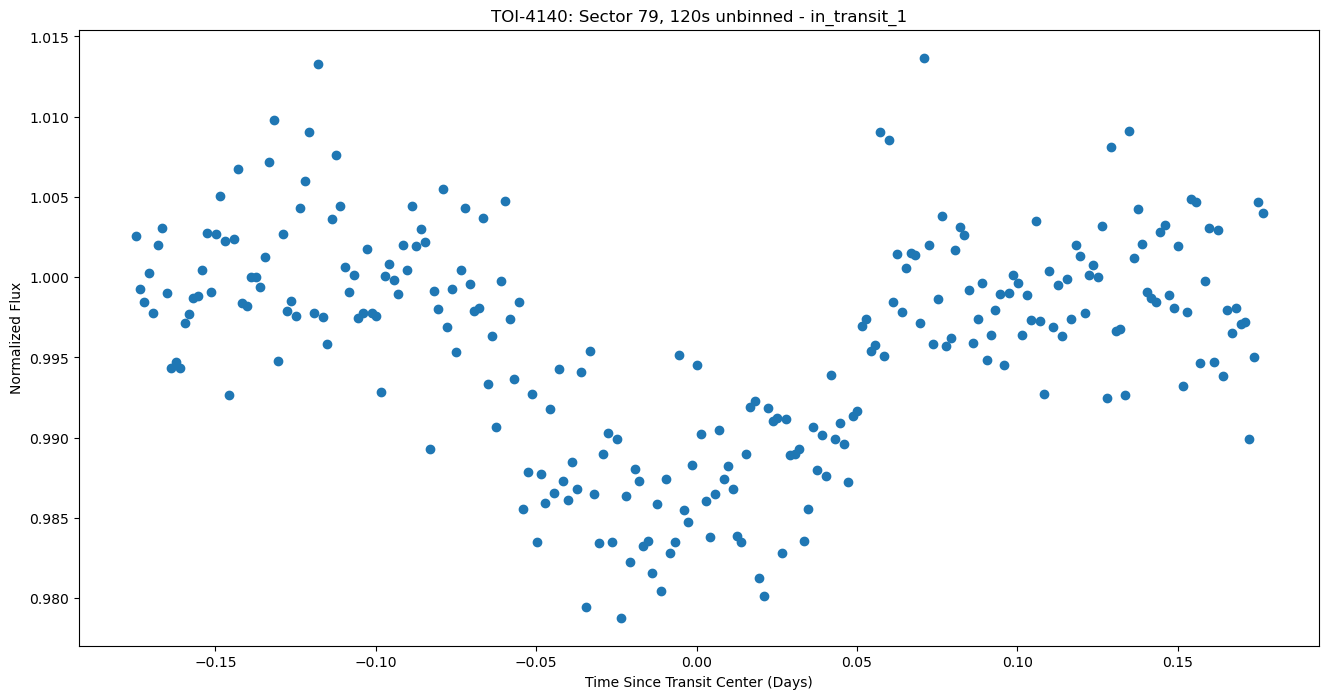

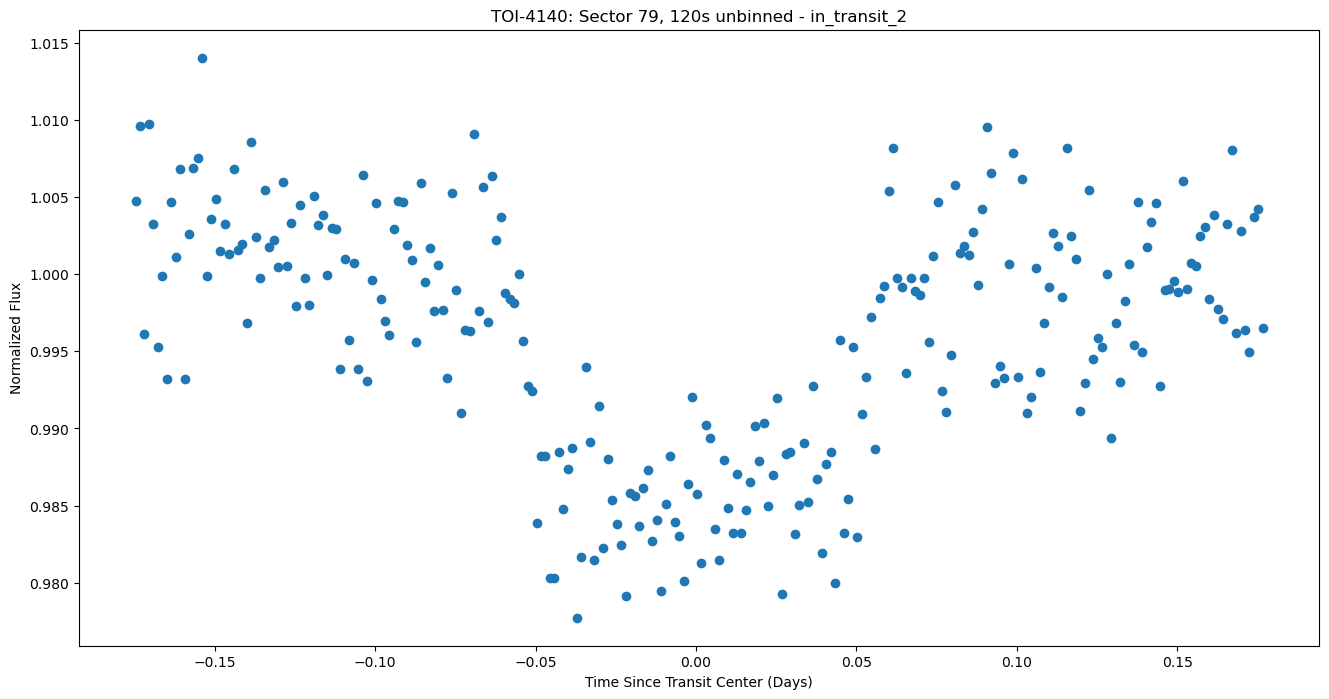

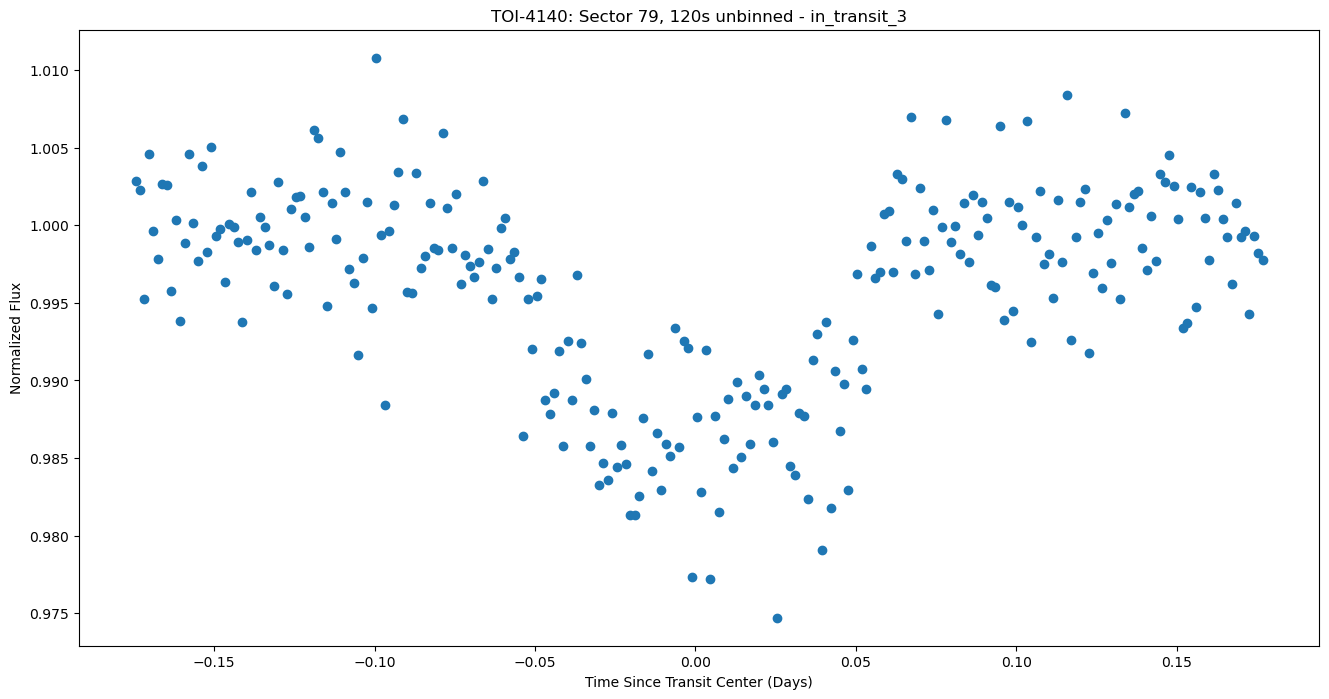

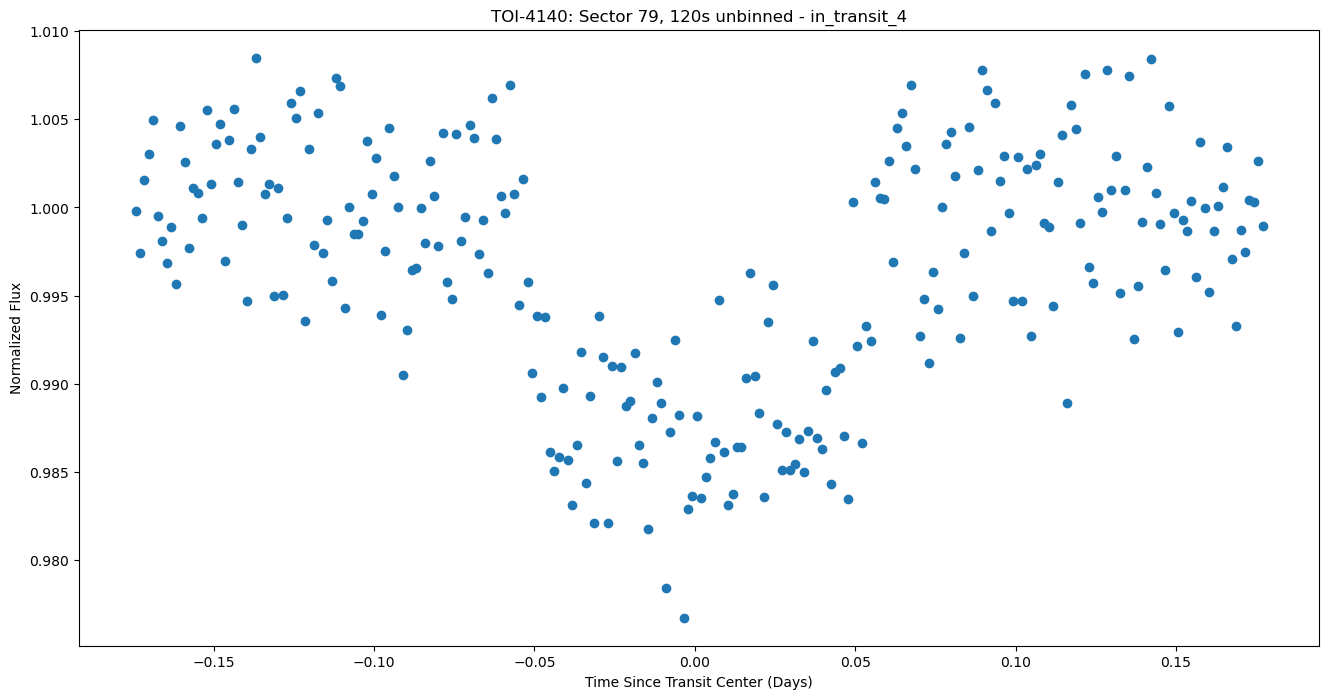

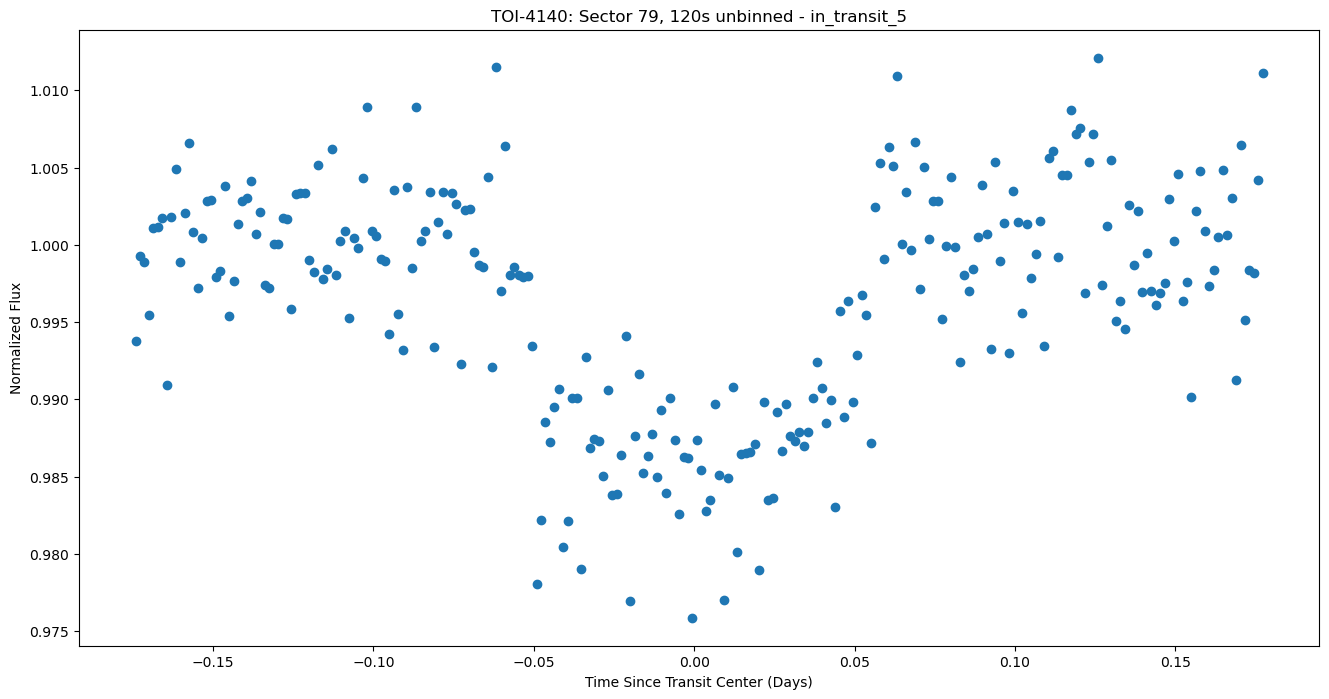

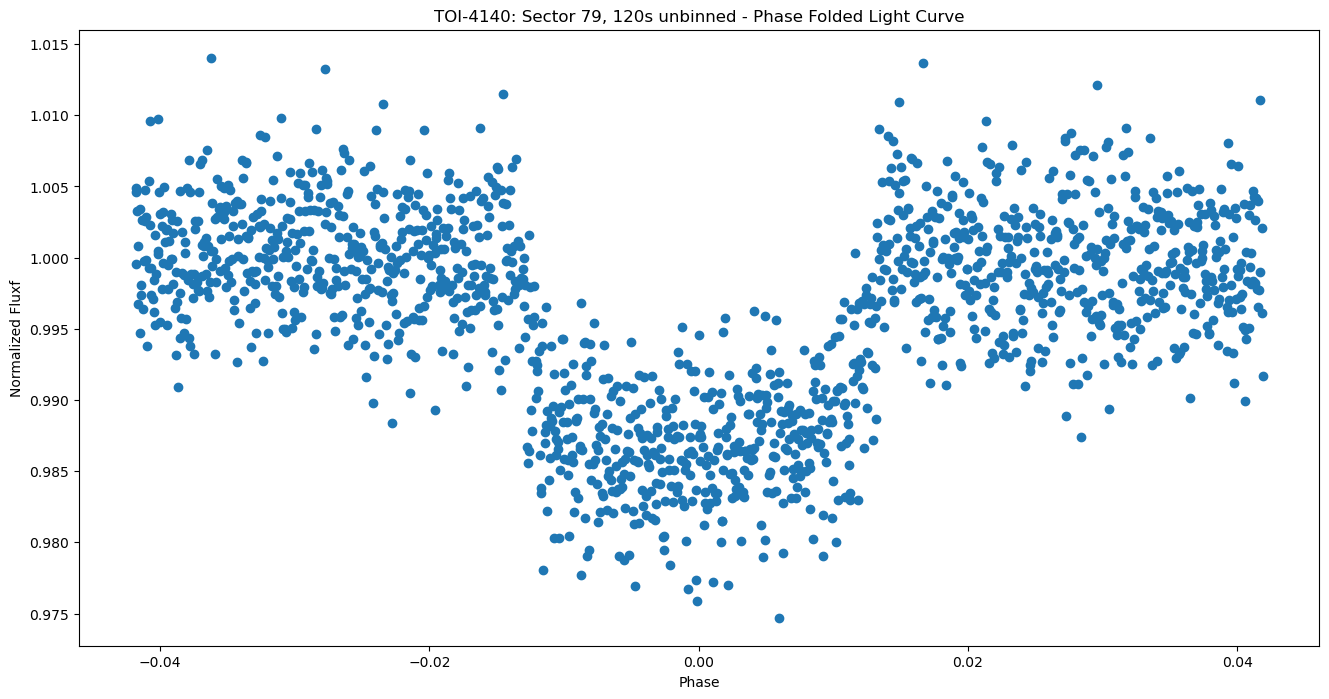

In [120]:
create_light_curve(f'TIC {ticid}', 'SPOC', 79, auto = True, exposure=120, targetname = f'TOI-{toi}', keep_secondary_eclipse=False,
                   ecosw = 0, save = True, plot = True, planet='b', published = False, qualityFlag = True, #omit_transit_index=[0],
                   outputfiles='slimflat', outputdir = outpath)

## Generating priors and SED
Before running this cell, create a directory to store the fit files and generate the prior and SED files using mkticsed. This cell will generate a separate text file containing the relevant priors and starting points. Append this to the end of the prior file generated by mkticsed, deleting the existing metallicity prior.

In [127]:
with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

# Auto tess_lcs and exptimes array creation (CHECK THE DF OR OUTPUT FILE BEFORE RUNNING FIT)
filtered_df = filtered_df.drop_duplicates(subset='mission') # keep only unique sectors
filtered_df = filtered_df[filtered_df['mission'].str.contains(r'\d+', regex=True)] # keep only numbered sectors
tess_lcs = np.ones(len(filtered_df), dtype=int) # booleans for whether or not each lightcurve is from TESS
exptimes = filtered_df['exptime'].values # array of exposure times for each lightcurve
exptimes = exptimes.astype(int) / 60 # convert to minutes

# tess_lcs = [1, 1, 1, 1, 1, 1, 1, 1, 1] # booleans for whether or not each lightcurve is from TESS
grab_all_priors(f'TOI-{toi}', tess_lcs=tess_lcs, outpath=outpath, feh_source='tres', tres_username='schulte', tres_password=password)

Starting points:
Tc = 2459910.467019
Period = 4.2511214
Rp/Rs = 0.11760102040373628
Spectroscopic [Fe/H] prior: 0.1846 +/- 0.0444
Dilution prior: 0.0 +/- 0.0006754


## Generating scripts to run the fit

After collecting all lightcurves, change the exptimes array in the following cell and then run it to generate the final files. By default, a dilution term will be fit for the TESS bands. After running the initial fit, if this is consistent with zero, it can be removed from the fit.

In [128]:
# exptimes = [30, 30, 30, 2, 2, 2, 2, 2, 2] # exposure times in minutes of included lightcurves (by index/chronological order)

generate_pro_file(toi, ticid, exptimes, tess_lcs=tess_lcs, outpath=outpath)
generate_SLURM_file(toi, outpath=outpath)